## 1D Euler Equation - Physics Informed Neural Network

Equation:
$$\frac{\partial Q}{\partial t} + \frac{\partial E}{\partial x} = 0$$
where, 
$$Q = \begin{pmatrix} \rho \\ \rho u \\ E \end{pmatrix}, \hspace{5pt} E = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ u(E + p) \end{pmatrix}$$
and $$E = \rho\left( \frac{p}{\rho (\gamma - 1)}  + \frac{1}{2}u^2 \right)$$
For moving contact discontinuity, the initial and boundary condition can be written as, 
$$ \begin{pmatrix} \rho_L \\ u_L \\ p_L \end{pmatrix} = \begin{pmatrix} 1.4 \\ 0.1 \\ 1.0 \end{pmatrix}, \hspace{5pt} \begin{pmatrix} \rho_R \\ u_R \\ p_R \end{pmatrix} = \begin{pmatrix} 1.0 \\ 0.1 \\ 1.0 \end{pmatrix}$$
and the initial shock position is at $x = 0.48$

In [1]:
from EulerEquation import Euler1D
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
key = jr.PRNGKey(0)

In [2]:
key, init_key = jr.split(key)
Euler = Euler1D(init_key, 10, 21, gamma=1.4)

### Define the domain, initial condition, boundary condition and collocation points

In [3]:
key, sampling_key = jr.split(key)

# Define the initial and boundary conditions
ICFunction = lambda x: Euler.primitiveToConserved(jnp.array([jnp.where((x < 0.48), 1.4, 1.0), 0.1, 1.0]))
BCLeft = Euler.primitiveToConserved(jnp.array([1.4, 0.1, 1.0]))
BCRight = Euler.primitiveToConserved(jnp.array([1.0, 0.1, 1.0]))

# Boundary points
sampling_key, xkey, tkey = jr.split(sampling_key, 3)
# x1 = jr.uniform(xkey, (12,), minval=0.001, maxval=0.45)  # Points in the region 0 < x < 0.45
# x2 = jr.uniform(xkey, (30,), minval=0.45, maxval=0.75)    # More points in the region 0.45 < x < 0.7
# x3 = jr.uniform(xkey, (8,), minval=0.75, maxval=1-0.001) # Points in the region 0.7 < x < 1
x = jr.uniform(xkey, (50,), minval=0.0, maxval=1.0) # jnp.concatenate([x1, x2, x3])  # Combine all points
t = jr.uniform(tkey, (50,), minval=0.0, maxval=1.0) 
BoundaryPoints = {'x': x, 't': t}
Conditions = {'IC': ICFunction, 'BCLeft': BCLeft, 'BCRight': BCRight, 'BoundaryPoints': BoundaryPoints}

# Define the collocation points for PINN training
sampling_key, key1, key2 = jr.split(sampling_key, 3)
X1 = jr.uniform(key1, (257,), minval=0.001, maxval=0.45)  # Points in the region 0 < x < 0.45
X2 = jr.uniform(key1, (600,), minval=0.45, maxval=0.75)    # More points in the region 0.45 < x < 0.7
X3 = jr.uniform(key1, (143,), minval=0.75, maxval=1-0.001) # Points in the region 0.7 < x < 1
X = jnp.concatenate([X1, X2, X3])  # Combine all points
T = jr.uniform(key2, (1000,), minval=0+0.001, maxval=1)

Text(0, 0.5, 't')

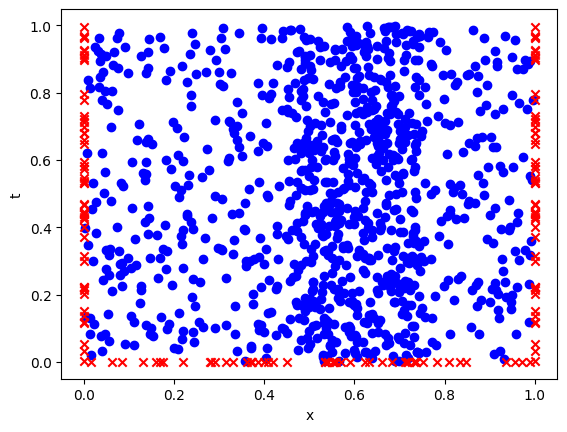

In [4]:
# Plot collocation points
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(X, T, label='Collocation Points', color='blue')

# Plot initial and boundary conditions
ax.scatter(x, jnp.zeros_like(x), color='red', label='IC', marker='x')
ax.scatter(0*jnp.ones_like(t), t,color='red', label='BC', marker='x')
ax.scatter(jnp.ones_like(t), t,color='red', label='BC', marker='x')

ax.set_xlabel('x')
ax.set_ylabel('t')

### Create Euler Equation Model and define loss function

In [5]:
@eqx.filter_jit
def lossFunction(network, X, T, Conditions):
    # PDE loss
    pdeResidual = jax.vmap(network.PDE, in_axes=(0, 0))(X, T)
    pde_loss = jnp.mean(jnp.square(pdeResidual), axis=0)

    # BC loss
    x = Conditions['BoundaryPoints']['x']
    t = Conditions['BoundaryPoints']['t']
    bc_loss_left = jnp.mean(jnp.square(jax.vmap(network, in_axes=(None, 0))(0, t) - Conditions['BCLeft']), axis=0) # Left BC
    bc_loss_right = jnp.mean(jnp.square(jax.vmap(network, in_axes=(None, 0))(1.0, t) - Conditions['BCRight']), axis=0) # Right BC    
    bc_loss = 0.5*bc_loss_left + 0.5*bc_loss_right

    # IC loss
    ic_loss = jnp.mean(jnp.square(jax.vmap(network, in_axes=(0, None))(x, 0.0) - jax.vmap(Conditions['IC'], in_axes=0)(x)), axis=0) # Initial Condition
    # print(f'pde_loss: {pde_loss}, bc_loss: {bc_loss}, ic_loss: {ic_loss}')

    return jnp.mean(pde_loss + 10*bc_loss + 20*ic_loss)

print("Loss: ", lossFunction(Euler, X, T, Conditions))
loss_history = []

Loss:  66.599815


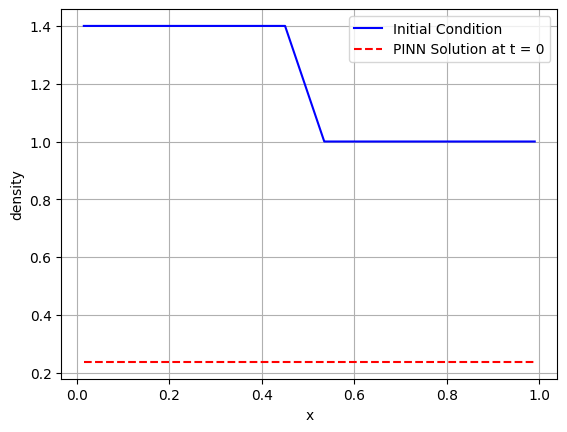

In [6]:
# Show the mismatch in IC of density 
plt.plot(jnp.sort(x), jax.vmap(Conditions['IC'])(jnp.sort(x))[:, 0], label="Initial Condition", color="blue")
plt.plot(jnp.sort(x), jax.vmap(Euler, in_axes=(0, None))(jnp.sort(x), 0.0)[:, 0], linestyle="--" ,label="PINN Solution at t = 0", color="red")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.grid()

In [7]:
# Training PINN
LEARNING_RATE = 1e-4
N_OPTIMIZATION_EPOCHS = 30000

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(Euler, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(lossFunction)(network, X, T, Conditions)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

for epoch in range(N_OPTIMIZATION_EPOCHS):
    Euler, opt_state, loss = make_step(Euler, opt_state)
    loss_history.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 66.59981536865234
Epoch: 1000, loss: 2.9587314128875732
Epoch: 2000, loss: 0.41103971004486084
Epoch: 3000, loss: 0.4014248549938202
Epoch: 4000, loss: 0.4014244079589844
Epoch: 5000, loss: 0.4014243483543396
Epoch: 6000, loss: 0.4014244079589844
Epoch: 7000, loss: 0.40142422914505005
Epoch: 8000, loss: 0.4014242887496948
Epoch: 9000, loss: 0.40142422914505005
Epoch: 10000, loss: 0.4014241099357605
Epoch: 11000, loss: 0.349158376455307
Epoch: 12000, loss: 0.0034216931089758873
Epoch: 13000, loss: 0.0002575531543698162
Epoch: 14000, loss: 0.00015488092321902514
Epoch: 15000, loss: 0.0001032860018312931
Epoch: 16000, loss: 6.461538578150794e-05
Epoch: 17000, loss: 3.9050253690220416e-05
Epoch: 18000, loss: 2.2762949811294675e-05
Epoch: 19000, loss: 1.3089147614664398e-05
Epoch: 20000, loss: 6.954810487513896e-06
Epoch: 21000, loss: 3.7891029478487326e-06
Epoch: 22000, loss: 2.1574146558123175e-06
Epoch: 23000, loss: 1.2756931937474292e-06
Epoch: 24000, loss: 5.17609635153

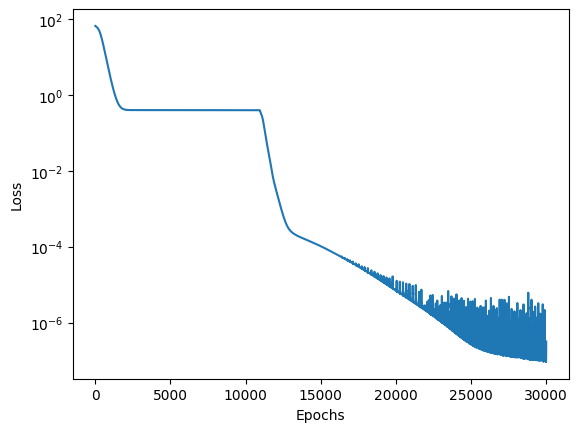

In [8]:
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Text(0, 0.5, 't')

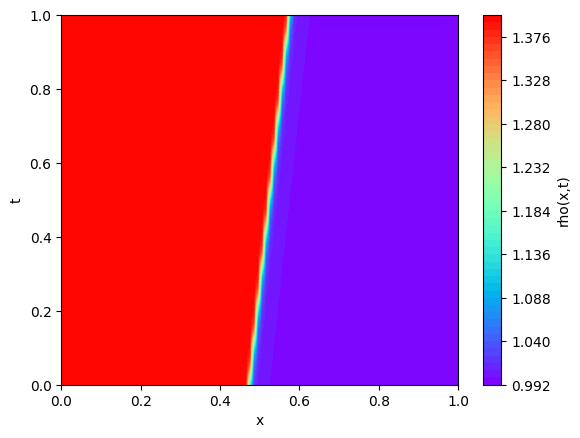

In [9]:
# Plot Euler Equation Solution
xarr = jnp.linspace(0, 1, 100)
tarr = jnp.linspace(0, 1, 100) 
Xmat, Tmat = jnp.meshgrid(xarr, tarr)
rhomat = jnp.zeros((len(xarr), len(tarr)))  # Initialize rho with the correct shape
umat = jnp.zeros((len(xarr), len(tarr)))  # Initialize rho with the correct shape
pmat = jnp.zeros((len(xarr), len(tarr)))  # Initialize rho with the correct shape
for i in range(len(xarr)):
    # Predict conserved variable from NN
    Qmat = jax.vmap(Euler, in_axes=(0, 0))(Xmat[i, :], Tmat[i, :])

    # Convert Conserved Variable to Primitive Variable
    Wmat = jax.vmap(Euler.conservedToPrimitive)(Qmat)

    # Store density, velocity and pressure in seperate arrays
    rhomat = rhomat.at[i, :].set(Wmat[:, 0])
    umat = umat.at[i, :].set(Wmat[:, 1])
    pmat = pmat.at[i, :].set(Wmat[:, 2])

# Plot the contour
fig, ax = plt.subplots()

# Contour plot
contour = ax.contourf(Xmat, Tmat, rhomat, levels=50, cmap='rainbow')
fig.colorbar(contour, ax=ax, label='rho(x,t)')
ax.set_xlabel("x")
ax.set_ylabel('t')

Text(0, 0.5, 't')

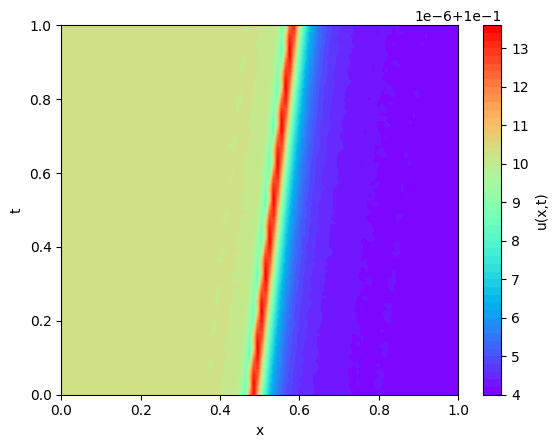

In [10]:
contour = plt.contourf(Xmat, Tmat, umat, levels=50, cmap='rainbow')
plt.colorbar(contour, label='u(x,t)')
plt.xlabel("x")
plt.ylabel('t')

Text(0, 0.5, 't')

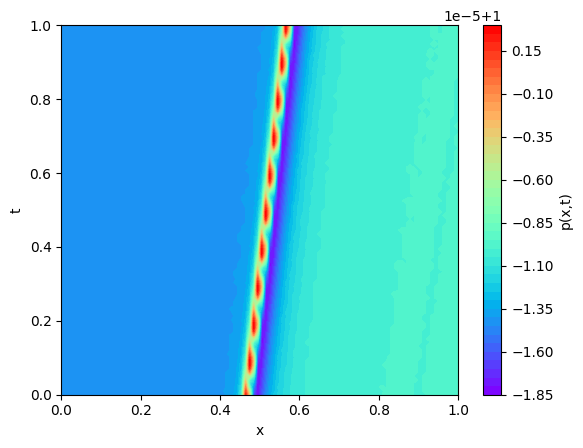

In [11]:
contour = plt.contourf(Xmat, Tmat, pmat, levels=50, cmap='rainbow')
plt.colorbar(contour, label='p(x,t)')
plt.xlabel("x")
plt.ylabel('t')

Text(0.5, 0, 'x')

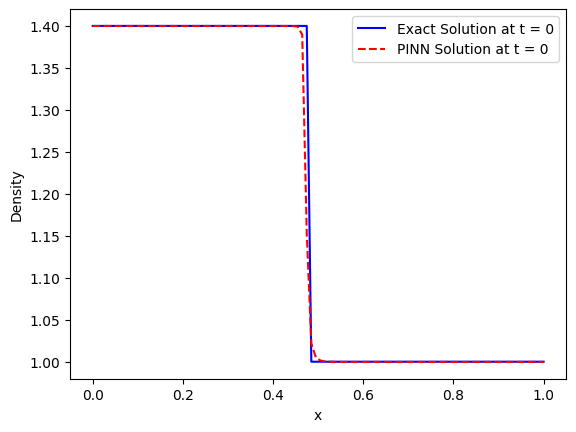

In [12]:
# Comoparison with exact solution
xplot = jnp.linspace(0, 1.0, 100)
time = 0;
rhoExact = jax.vmap(lambda x: jnp.where(x < 0.48 + 0.1*time, 1.4, 1.0))(xplot)
plt.plot(xplot, rhoExact, linestyle="-", color="blue", label="Exact Solution at t = 0")
plt.plot(xplot, jax.vmap(Euler, in_axes=(0, None))(xplot, time)[:, 0], linestyle="--", color="red", label="PINN Solution at t = 0")
plt.legend()
plt.ylabel("Density")
plt.xlabel("x")
